# A1
## Group 8
**Submitted by: ZHANG Zhiyuan, 20030624-T126, zhizhan@student.chalmers.se** <br />
**Submitted by: LI Chenzhao, , chenzhao@chalmers.se** <br />

# Task 0

In [2]:
# !python --version
# !which -a python
# !which -a pip
# %pip install pandas scikit-learn numpy matplotlib seaborn

In [3]:
import os

os.getcwd()

'/Users/hollyzhang/Documents/GitHub/Applied-ML-2024/Assignment'

# Task 1

## Step 1

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Read the CSV file.
data = pd.read_csv("./A1_CTG.csv", skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)


# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]


Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [5]:
X.head(3)

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
658,130.0,1.0,0.0,3.0,0.0,0.0,0.0,24.0,1.2,12.0,...,35.0,120.0,155.0,1.0,0.0,134.0,133.0,135.0,1.0,0.0
1734,134.0,9.0,1.0,8.0,5.0,0.0,0.0,59.0,1.2,0.0,...,109.0,80.0,189.0,6.0,0.0,150.0,146.0,150.0,33.0,0.0
1226,125.0,1.0,0.0,4.0,0.0,0.0,0.0,43.0,0.7,31.0,...,21.0,120.0,141.0,0.0,0.0,131.0,130.0,132.0,1.0,0.0


22


<Axes: title={'center': 'Correlation Matrix'}>

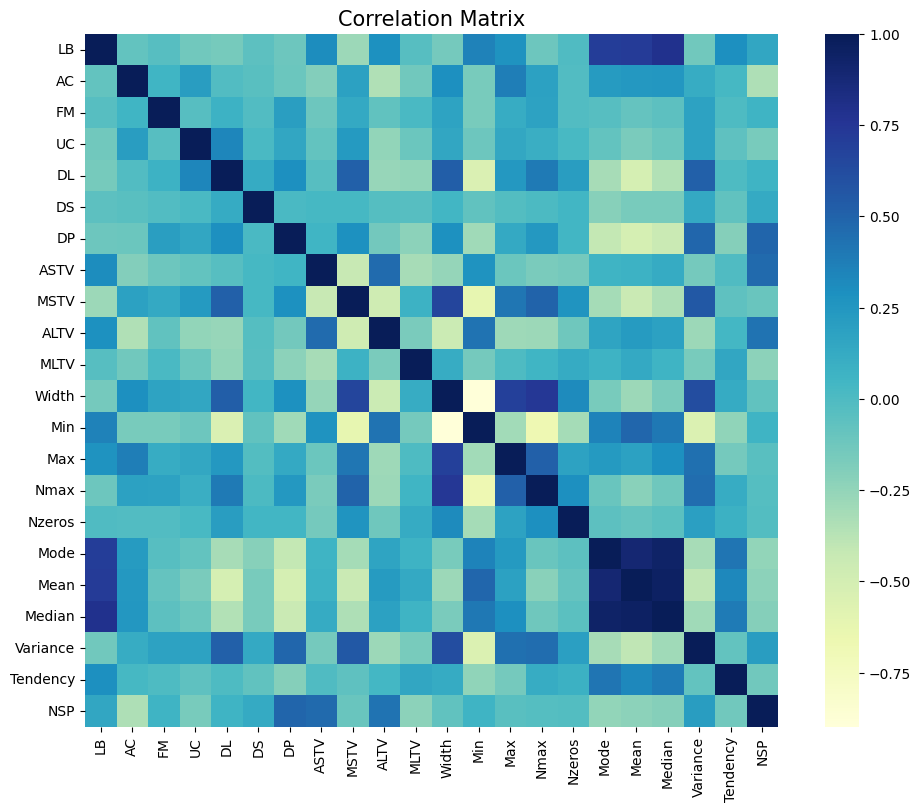

In [6]:
#Correlation map to see how features are correlated with SalePrice
import matplotlib.pyplot as plt
import seaborn as sns

print(len(data.columns))
corrmat = data.corr()
plt.subplots(figsize=(12, 9))
plt.title('Correlation Matrix', fontsize=15)
sns.heatmap(corrmat, square=True, cmap="YlGnBu")

## Step 2

### Baseline

In [7]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, Xtrain, Ytrain).mean()

0.7805882352941176

## Step 3

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

DTree = DecisionTreeClassifier()
RForest = RandomForestClassifier()
GBoost = GradientBoostingClassifier()

DTree.fit(Xtrain, Ytrain)
RForest.fit(Xtrain, Ytrain)
GBoost.fit(Xtrain, Ytrain)

DTree_score = cross_val_score(DTree, Xtrain, Ytrain).mean()
RForest_score = cross_val_score(RForest, Xtrain, Ytrain).mean()
GBoost_score = cross_val_score(GBoost, Xtrain, Ytrain).mean()

print("Decision Tree:", DTree_score)
print("Random Forest:", RForest_score)
print("Gradient Boosting:", GBoost_score)

Decision Tree: 0.9270588235294117
Random Forest: 0.9405882352941177
Gradient Boosting: 0.9488235294117647


### emmmmmmmm .......

In [10]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import LinearSVC

# Perceptron
perceptron = Perceptron(random_state=0)
perceptron.fit(Xtrain, Ytrain)

# Logistic Regression
logreg = LogisticRegression(random_state=0)
logreg.fit(Xtrain, Ytrain)

# Linear SVM
linear_svm = LinearSVC(random_state=0)
linear_svm.fit(Xtrain, Ytrain)

# Cross-validation
Per_score = cross_val_score(perceptron, Xtrain, Ytrain).mean()
LogReg_score = cross_val_score(logreg, Xtrain, Ytrain).mean()
LSVM_score = cross_val_score(linear_svm, Xtrain, Ytrain).mean()

print("Perceptron:", Per_score)
print("Logistic Regression:", LogReg_score)
print("Linear SVM:", LSVM_score)

/Users/hollyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hollyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/hollyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hollyzhang/Libr

Perceptron: 0.825294117647059
Logistic Regression: 0.8747058823529411
Linear SVM: 0.8452941176470589


/Users/hollyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(15, 10, 6), max_iter=200, random_state=0)
mlp.fit(Xtrain, Ytrain)
mlp_score = cross_val_score(mlp, Xtrain, Ytrain).mean()
print("MLP Score:", mlp_score)

/Users/hollyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hollyzhang/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Score: 0.878235294117647


## Step 4

In [12]:
GBoost.fit(Xtrain, Ytrain)
Yguess = GBoost.predict(Xtest)
print(accuracy_score(Ytest, Yguess))

0.9295774647887324


# Task 2: Decision trees for classification
See `Lecture 1_pre.ipynb` fine-tune section

# Task 3: A regression example

In [13]:
# Read the CSV file using Pandas.
alldata = pd.read_csv("./A1_sberbank.csv")


# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])


alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [14]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

m1 = DummyRegressor()
cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')

{'fit_time': array([0.00099397, 0.00074387, 0.00068402, 0.00055718, 0.00058389]),
 'score_time': array([0.00028968, 0.00027204, 0.00025606, 0.00021887, 0.00022006]),
 'test_score': array([-0.39897319, -0.37113485, -0.38083108, -0.39057156, -0.40475168])}

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Linear Regression
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)

# Ridge Regression
ridge = Ridge()
ridge.fit(Xtrain, Ytrain)

# Lasso Regression
lasso = Lasso()
lasso.fit(Xtrain, Ytrain)

# Decision Tree Regressor
dt = DecisionTreeRegressor()
dt.fit(Xtrain, Ytrain)

# Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(Xtrain, Ytrain)

# Gradient Boosting Regressor
gb = GradientBoostingRegressor()
gb.fit(Xtrain, Ytrain)

# MLP Regressor
mlp = MLPRegressor()
mlp.fit(Xtrain, Ytrain)

lr_score = cross_validate(lr, Xtrain, Ytrain, scoring='neg_mean_squared_error')["test_score"].mean()
ridge_score = cross_validate(ridge, Xtrain, Ytrain, scoring='neg_mean_squared_error')["test_score"].mean()
lasso_score = cross_validate(lasso, Xtrain, Ytrain, scoring='neg_mean_squared_error')["test_score"].mean()
dt_score = cross_validate(dt, Xtrain, Ytrain, scoring='neg_mean_squared_error')["test_score"].mean()
rf_score = cross_validate(rf, Xtrain, Ytrain, scoring='neg_mean_squared_error')["test_score"].mean()
gb_score = cross_validate(gb, Xtrain, Ytrain, scoring='neg_mean_squared_error')["test_score"].mean()
mlp_score = cross_validate(mlp, Xtrain, Ytrain, scoring='neg_mean_squared_error')["test_score"].mean()

print("Linear Regression:", lr_score)
print("Ridge Regression:", ridge_score)
print("Lasso Regression:", lasso_score)
print("Decision Tree Regressor:", dt_score)
print("Random Forest Regressor:", rf_score)
print("Gradient Boosting Regressor:", gb_score)
print("MLP Regressor:", mlp_score)

Linear Regression: -0.3013986588767263
Ridge Regression: -0.30139784232179734
Lasso Regression: -0.3010470671748873
Decision Tree Regressor: -0.5220465022623048
Random Forest Regressor: -0.2846114405730435
Gradient Boosting Regressor: -0.2645336534028367
MLP Regressor: -89.15814527395047


### Smaller MSE == better performance

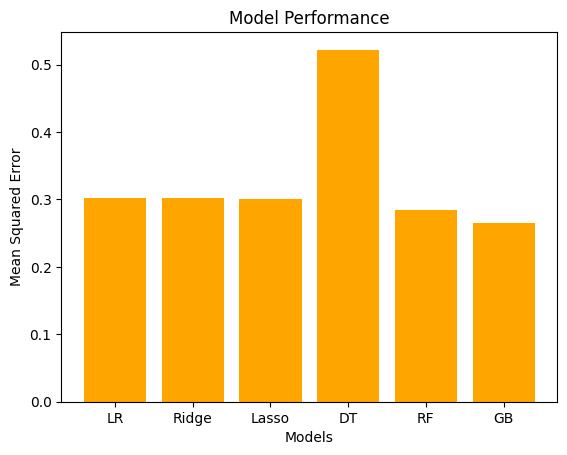

In [16]:
# Assuming the scores are negative mean squared errors, we take the negative of the scores to get the MSE.
scores = [-lr_score, -ridge_score, -lasso_score, -dt_score, -rf_score, -gb_score]  #, -mlp_score]
labels = ['LR', 'Ridge', 'Lasso', 'DT', 'RF', 'GB']  #, 'MLP']

plt.bar(labels, scores, color='orange')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance')
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error

gb.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, gb.predict(Xtest))


0.2714740305846131

# Task 4: Decision trees for regression

In [ ]:
from collections import Counter

## TODO

In [ ]:
#TODO
class TreeClassifier(DecisionTree, RegressorMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point


## Step 2

In [18]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1 * np.random.normal(size=n)
    X = x.reshape(n, 1)  # X needs to be a 2-dimensional matrix
    return X, Y